In [ ]:
!pip install wget
!pip install wandb
!pip install xtarfile

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a8799cc62ef93a9cf20fe35a50e57d35914174c4f556ea144a277069b4132d92
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 1.8 MB 7.0 MB/s 
     |████████████████████████████████| 181 kB 80.1 MB/s 
     |████████████████████████████████| 144 kB 71.8 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=b68e917846ed9f89604e27d28552bf146158ef015cc6c8fc272d72ce9a96cd07
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Created wheel for xtarfile: filename=xtarfile-0.1.0-py3-none-any.whl size=3862 sha256=fedca80267beb81dd804d5bba06ec0ba9f0948aee569d23d182de68e43b88db2
  Stored in directory: /root/.cache/pip/wheels/14/ed/

### Configuration

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
from os.path import exists
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import numpy as np
import keras
import tensorflow as tf
import xtarfile as tarfile
import csv
class Dataset:
    
    def downloadDataSet(self):
      cwd = os.getcwd()
     
      file_exists = exists('./dakshina_dataset_v1.0.tar')
      if(file_exists==False):
        print('downloading....')
        os.system('curl -SL https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar > dakshina_dataset_v1.0.tar')
        print('download Complete')
      extract_exists = exists('./dakshina_dataset_v1.0/')   
      if(extract_exists==False): 
        print('Extracting..') 
        with tarfile.open('dakshina_dataset_v1.0.tar', 'r') as archive:
            archive.extractall()
        print('Complete')

      print('You are all set')

    def readData(self,dir,start_token="\t",end_token="\n"):
      # Vectorize the data.
      input_texts=list()
      target_texts=list()
      input_characters = set()
      target_characters = set()
      with open(dir, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
      
      for line in lines:
          ln = line.split("\t")
          if(len(ln)==3):
            target_text=ln[0].strip()  
            input_text=ln[1].strip()+start_token
            target_text = start_token + target_text + end_token
            input_texts.append(input_text)
            target_texts.append(target_text)
            for char in input_text:
              if char not in input_characters:
                input_characters.add(char)
            for char in target_text:
             if char not in target_characters:
               target_characters.add(char)
      input_characters = sorted(list(input_characters))
      target_characters = sorted(list(target_characters))
      return input_texts,target_texts,input_characters,target_characters


   

    #def encode_decode_characters(self,train_input, train_target, val_input=[], val_target=[],start_token="\t",end_token="\n"):
    def encode_decode_characters(self,train_input, train_target,start_token="\t",end_token="\n"):
        # Returns the encoding for characters to integer (as a dictionary) and decoding for integers to characters (as a list) for in
        BLANK_CHAR=' '
        # Encoding and decoding of input vocabulary
        input_char_enc = {}
        input_char_dec = []
        max_encoder_seq_length = 1
        tmplist=[]
        for i in train_input:
            tmplist.append(i)
        """for i in val_input:
            tmplist.append(i)"""
        for string in tmplist:
            max_encoder_seq_length = max(max_encoder_seq_length, len(string))
            for char in string:
                if char not in input_char_enc:
                    input_char_enc[char] = len(input_char_dec)
                    input_char_dec.append(char)
        if BLANK_CHAR not in input_char_enc:
            input_char_enc[BLANK_CHAR] = len(input_char_dec)
            input_char_dec.append(BLANK_CHAR)

        # Encoding and decoding of target vocabulary
        target_char_enc = {}
        target_char_dec = []
        target_char_enc[start_token] = len(target_char_dec)
        target_char_dec.append(start_token)
        max_decoder_seq_length = 1
        for string in train_target :#+ val_target:
            max_decoder_seq_length = max(max_decoder_seq_length, len(string)+2)
            for char in string:
                if char not in target_char_enc:
                    target_char_enc[char] = len(target_char_dec)
                    target_char_dec.append(char)
        target_char_enc[end_token] = len(target_char_dec)
        target_char_dec.append(end_token)
        if ' ' not in target_char_enc:
            target_char_enc[BLANK_CHAR] = len(target_char_dec)
            target_char_dec.append(BLANK_CHAR)

        """print("Number of training samples:", len(train_input))
        print("Number of validation samples:", len(val_input))
        print("Number of unique input tokens:", len(input_char_dec))
        print("Number of unique output tokens:", len(target_char_dec))
        print("Max sequence length for inputs:", max_encoder_seq_length)
        print("Max sequence length for outputs:", max_decoder_seq_length)"""

        return input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length
    def preprocessing(self,input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length,input_texts,target_texts,start_token="\t",end_token="\n"):
        encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, len(input_char_dec)), dtype="float32")
        decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, len(target_char_dec)), dtype="float32")
        decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, len(target_char_dec)), dtype="float32")
        for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
            for t, char in enumerate(input_text):
                encoder_input_data[i, t, input_char_enc[char]] = 1.0
            encoder_input_data[i, t + 1 :, input_char_enc[start_token]] = 1.0

            for t, char in enumerate(target_text):
                # decoder_target_data is ahead of decoder_input_data by one timestep
                decoder_input_data[i, t, target_char_enc[char]] = 1.0
                if t > 0:
                    # decoder_target_data will be ahead by one timestep
                    # and will not include the start character.
                    decoder_target_data[i, t - 1, target_char_enc[char]] = 1.0
            decoder_input_data[i, t + 1 :, target_char_enc[" "]] = 1.0
            decoder_target_data[i, t:, target_char_enc[" "]] = 1.0
        return encoder_input_data,decoder_input_data,decoder_target_data


       
   

### Read data from dataset

In [ ]:
ds=Dataset()
ds.downloadDataSet()
language='hi'
train_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.train.tsv'
val_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.dev.tsv'
test_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.test.tsv'


You are all set


In [ ]:
train_ip_txt,train_op_txt,train_ip_chr,train_op_chr=ds.readData(train_dir)

val_ip_txt,val_op_txt,val_ip_chr,val_op_chr=ds.readData(val_dir)
test_ip_txt,test_op_txt,test_ip_chr,test_op_chr=ds.readData(test_dir)

### Preprocessing data

In [ ]:
"""input_char_enc, input_char_dec,\
 target_char_enc,\
target_char_dec,\
max_encoder_seq_length,\
max_decoder_seq_length\
=ds.encode_decode_characters(train_ip_txt, train_op_txt, val_ip_txt, val_op_txt)"""

input_char_enc, input_char_dec,\
target_char_enc,\
target_char_dec,\
max_encoder_seq_length,\
max_decoder_seq_length\
=ds.encode_decode_characters(train_ip_txt, train_op_txt)

In [ ]:
# Assigning training, validation and test encoder input, decoder input, decoder output
train_enc_input, train_dec_input, train_dec_target\
= ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length,train_ip_txt, train_op_txt)



In [ ]:
val_enc_input, val_dec_input, val_dec_target = \
ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,\
                 max_encoder_seq_length,max_decoder_seq_length,val_ip_txt, val_op_txt)


test_enc_input, test_dec_input, test_dec_target =\
 ds.preprocessing(input_char_enc, input_char_dec, target_char_enc, target_char_dec,max_encoder_seq_length,max_decoder_seq_length\
                  ,test_ip_txt, test_op_txt)


### Custom Validation

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 5  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.

### define model

In [ ]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class seqTOseq:
  def parameters(self,input_char_dec,target_char_dec,latent_dim=64,cell_type="lstm",optimizer="rmsprop"):
      self.num_encoder_tokens=len(input_char_dec)
      self.num_decoder_tokens=len(target_char_dec)
      self.latent_dim=latent_dim
      self.cell_type=cell_type
      self.optimizer=optimizer
  def model(self):
      
      from keras.utils.vis_utils import plot_model
      if(self.cell_type=="rnn"):
         cell=keras.layers.SimpleRNN
      if(self.cell_type=="lstm"):
        cell=keras.layers.LSTM     
      if(self.cell_type=="gru"):
         cell=keras.layers.GRU
      # Define an input sequence and process it.
      encoder_inputs = keras.Input(shape=(None, self.num_encoder_tokens))
      
      encoder =cell(self.latent_dim, return_state=True,return_sequences=True)         
      encoder_outputs, *encoder_states = encoder(encoder_inputs)
      # We discard `encoder_outputs` and only keep the states.
      

      # Set up the decoder, using `encoder_states` as initial state.
      decoder_inputs = keras.Input(shape=(None, self.num_decoder_tokens))

      # We set up our decoder to return full output sequences,
      # and to return internal states as well. We don't use the
      # return states in the training model, but we will use them in inference.
      
      decoder=cell(self.latent_dim ,return_sequences=True, return_state=True)  
      decoder_outputs, *decode_states=decoder(decoder_inputs, initial_state=encoder_states)
      decoder_dense = keras.layers.Dense(self.num_decoder_tokens, activation="softmax")
      decoder_outputs = decoder_dense(decoder_outputs)

      # Define the model that will turn
      # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
      model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
      model.compile(optimizer=self.optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
      return model
  def modelSummary(self,model):
      plot_model(model, to_file='encoder_model.png', show_shapes=True)
      f = plt.figure()
      f.set_figwidth(20)
      f.set_figheight(20)
      plt.imshow(mpimg.imread('encoder_model.png'))
      plt.axis('off')


In [ ]:
seq=seqTOseq()
seq.parameters(input_char_dec=input_char_dec,\
               target_char_dec=target_char_dec,\
               latent_dim=64,\
               cell_type="gru")

model=seq.model()

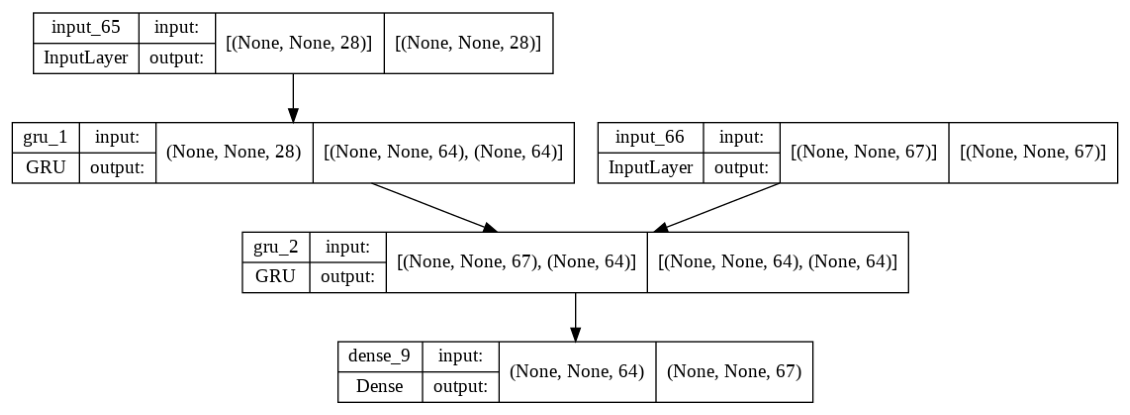

In [ ]:
seq.modelSummary(model)

In [ ]:
model.fit(
    [train_enc_input, train_dec_input],
    train_dec_target,
    batch_size=batch_size,
    epochs=epochs,
   validation_data=([val_enc_input, val_dec_input ] ,val_dec_target)
)
# Save model
model.save("s2s")

Epoch 1/5
691/691 [==============================] - 8s 7ms/step - loss: 1.0563 - accuracy: 0.7416 - val_loss: 0.8353 - val_accuracy: 0.7762
Epoch 2/5
691/691 [==============================] - 5s 7ms/step - loss: 0.8272 - accuracy: 0.7755 - val_loss: 0.7860 - val_accuracy: 0.7829
Epoch 3/5
691/691 [==============================] - 4s 6ms/step - loss: 0.7876 - accuracy: 0.7826 - val_loss: 0.7382 - val_accuracy: 0.7940
Epoch 4/5
691/691 [==============================] - 4s 6ms/step - loss: 0.7477 - accuracy: 0.7906 - val_loss: 0.7080 - val_accuracy: 0.7997
Epoch 5/5
691/691 [==============================] - 4s 6ms/step - loss: 0.7209 - accuracy: 0.7962 - val_loss: 0.6937 - val_accuracy: 0.8047


INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets
